<a href="https://colab.research.google.com/github/zoebatz/CAP6640_Project/blob/main/NLP_gpt_TR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sacrebleu
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 req

In [20]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c01772ab81054a0a5496a36f46b2c6b77be34978fac0e5b889a5199dc2518317
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import openai
import pandas as pd
import numpy as np
import os
import kagglehub



from google.colab import userdata

# print(openai.__version__)
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_NLP')

In [18]:

import sacrebleu
from nltk.translate.meteor_score import meteor_score
import nltk
import evaluate

# Download necessary resources for METEOR
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional but recommended
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [57]:
# import data from google drive
file_name = "data_eng_greek"

path = "/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/data/"+file_name+".csv"
data = pd.read_csv(path)
data.head()



,english,greek
0,You must clear the table.,Πρέπει να καθαρίσεις το τραπέζι.
1,He came to Japan when he was 10 years old.,"Ήρθε στην Ιαπωνία, όταν ήταν 10 ετών."
2,Your friends are waiting for you.,Οι φίλοι σας σας περιμένουν.
3,Tom wants to be a lawyer.,Ο Τομ θέλει να γίνει δικηγόρος.
4,Are you ready for spring?,Είσαι έτοιμος για την άνοιξη?


In [58]:
len(data)

200

In [59]:
'''# check if english sentence is in dataset
sent =
# 'where is the bathroom?'
#'I understand a little greek.'
#'I would like to eat something'

if data['english'].str.contains(sent, case=False).any():
  # print index found at
  print(data[data['english'].str.contains(sent, case=False)].index)
  print(data[data['english'].str.contains(sent, case=False)]['english'])

else:
  print("Not found")





SyntaxError: incomplete input (<ipython-input-59-db6173958c00>, line 1)

In [60]:
zero_shot = f""" """

one_shot = f"""
              Input: "I would ike to eat something."
              Output: "θα ήθελα να φάω κάτι."
"""

three_shot = f"""
              Input: "I understand a little greek. "
              Output: "καταλαβαίνω λίγα ελληνικά. "
              Input: "Where is the bathroom? "
              Output: "πού είναι το τουαλέτα?"
              Input: "My grandma is greek."
              Output: "η γιαγιά μου είναι Ελληνίδα. "
"""


In [61]:
# text classification with GPT

def translate_text(text):
    try:
        # Call GPT-3.5 Turbo
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a translator assistant who translates from English to Greek. Given a phrase in English, repsond with the translated phrase in Greek."},
                {"role": "assistant", "content": shot},
                {"role": "user", "content": text}
            ]
        )
        # Extract and return the response
        translation = response.choices[0].message.content.strip()
#       print(response.choices[0].message.content)
        return translation
    except Exception as e:
        return f"Error: {e}"

In [62]:
# adjust for desired prompt / model / data size
test_size = len(data)   # can adjust for smaller testing

function = translate_text
shot_name = "three_shot"      # change for zero / one / three shot
model_name = "gpt-3.5-turbo"  # change for different models

In [63]:

prediction = []

if shot_name == "one_shot":
  shot = one_shot
elif shot_name == "three_shot":
  shot = three_shot
else:
  shot = zero_shot



def translate(data):
  count = 0
  for i, texts in enumerate(data.english[:test_size]):
    result = function(texts)
    count += 1
    if count % 100 == 0:
      print(count)

    prediction.append(result)



In [64]:
translate(data)


100
200


In [11]:
len(prediction)

200

In [65]:
# greek to list
reference = data.greek[:test_size].tolist()


In [66]:
bleu = sacrebleu.corpus_bleu(prediction, [reference])
print(bleu.score)

49.546625638124986


In [67]:
file_name

'data_eng_greek'

In [68]:
shot_name


'three_shot'

In [63]:
'''# print predictions and references to compare
for i in range(len(prediction)):
  print(f'{prediction[i]} \n{reference[i]}\n')

Πρέπει να καθαρίσεις το τραπέζι. 
Πρέπει να καθαρίσεις το τραπέζι.

Ήρθε στην Ιαπωνία όταν ήταν 10 ετών. 
Ήρθε στην Ιαπωνία, όταν ήταν 10 ετών.

Οι φίλοι σου σε περιμένουν. 
Οι φίλοι σας σας περιμένουν.

Ο Τομ θέλει να γίνει δικηγόρος. 
Ο Τομ θέλει να γίνει δικηγόρος.

Είσαι έτοιμος για την άνοιξη; 
Είσαι έτοιμος για την άνοιξη?

Ο Τομ περπατά πολύ αργά. 
Ο Τομ περπατάει πολύ αργά.

Η οικογένεια του Τομ ζει στο Μπόστον. 
Η οικογένεια του Τομ μένει στη Βοστώνη.

Είμαι 25 ετών. 
Είμαι 25 χρόνων.

Ο Τομ γνώριζε την απάντηση. 
Ο Τομ γνώριζε την απάντηση.

Αγαπώ τη δουλειά μου. 
Λατρεύω τη δουλειά μου.



In [69]:
size = len(prediction)


In [70]:
# view metrics and save
def view_and_save_metrics(prediction, reference):
  # BLEU
  bleu = sacrebleu.corpus_bleu(prediction, [reference])
#  print(f"BLEU: {bleu.score}")

  # Tokenize sentences for METEOR
  prediction_tokens = [nltk.word_tokenize(pred) for pred in prediction]
  reference_tokens = [[nltk.word_tokenize(ref)] for ref in reference]  # Note the double list for reference

  # METEOR (sentence-level average)
  meteor_scores = [
      meteor_score(ref_tokens, pred_tokens)
      for ref_tokens, pred_tokens in zip(reference_tokens, prediction_tokens)
  ]
  avg_meteor = sum(meteor_scores) / len(meteor_scores)

  # ROUGE
  rouge = evaluate.load('rouge')
  rouge_scores = rouge.compute(predictions=prediction, references=reference)
#  print(f"ROUGE: {rouge_scores}")


  metrics = {
      "bleu": bleu.score,
      "meteor": avg_meteor,
      "model_name": model_name,
      "dataset": file_name
  }

  metrics.update(rouge_scores)
  '''
  # Print all metrics
  print("\n--- Evaluation Metrics ---")
  print(f"BLEU:   {bleu.score:.4f}")
  print(f"METEOR: {avg_meteor:.4f}")
  for k, v in rouge_scores.items():
      print(f"{k.upper()}: {v:.4f}")
  '''

  # save metrics to csv file
  metrics_df = pd.DataFrame([metrics])
  metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/translation/metrics_'+model_name+'_'+file_name+'_'+shot_name+'_'+str(size)+'.csv', index=False)


In [71]:
view_and_save_metrics(prediction, reference)

In [31]:
metrics

,bleu,meteor,model_name,dataset,rouge1,rouge2,rougeL,rougeLsum
0,52.143837,0.723911,gpt-3.5-turbo,data_eng_greek,0.02,0.005,0.02,0.02


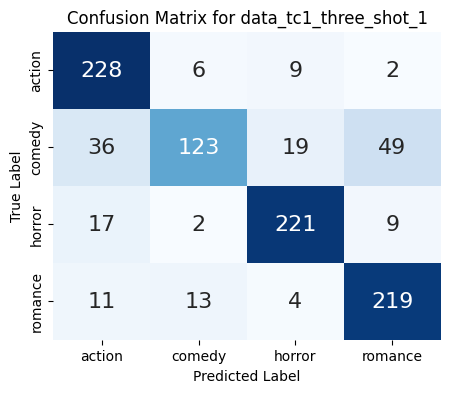

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data.genre, prediction)

# Define class labels
labels = ["action", "comedy", "horror", "romance"]

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {file_name}_{shot_name}_{handle_option}")
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/text_classification/confusion_matrix_{file_name}_{shot_name}_{handle_option}.png")
plt.show()
